Created on Thu Feb  2 14:12:22 2017

@author: wijers

takes a .npz box (region) projection from make_maps, convolves with a PSF, 
selects a region if needed

input: 
 - 2D array repesenting emission
 - angle subtended by an image pixel
 - centre on chip (pixel coordinates)
 - angle of chip long axis wrt image x-axis (radians)
output:
 - photon counts or ergs per second (as in input file) per pixel
 
It looks like her development started from the bottom functions and then moved upwards.  So far it looks like she started with individual functions for the different kernels, and she was developing them so that you only had to call one function and it would handle the different types of kernels as inputs.

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy as asp
import astropy.convolution as cnv
import os.path
import get_halpha_SB

import eagle_constants_and_units as cons
#import loadnpz_and_plot as lnp
from cosmo_utils import comoving_distance_cm # loading all of make_maps means the entire read_eagle machinary too 

# working units: cgs, radians

radians = 1.
degrees = np.pi/180.
arcmin = 1./60. * degrees 
arcsec = 1./3600. * degrees

g = 1.
kg = 10.**3 * g

s = 1.
Hz = 1/s

cm = 1.
nm = 10.**-7 * cm
mum = 10**-4 * cm

erg = 1.

Jy = 10**-23 * erg/(s*cm**2) *1/Hz  



In [2]:
# Dragonfly CCD data (current)
data_version = 1
saved_kernels = 'dragonfly_kernels_dataversion%s' %str(data_version)
saved_abr_fftkernels = 'dragonfly_abr_fftkernels_dataversion%s' %str(data_version)

FOV = (2.6*degrees, 1.9*degrees)
numpix_dr = (3326,2504)
pix_size_phys = 5.4 *mum
pix_size_angle = 2.8 * arcsec
seeing_limit = 1.5*arcsec #typically 1.5--2.0 in long exposures according to the dragonfly paper

def diffraction_limit(wavelength):
    return 0.65*arcsec * wavelength/(450.*nm)
def airy_size(wavelength): #3.1 mum diamater of Airy disc; used as distance to first Airy zero
    return 3.1*mum/2. * wavelength/(450.*nm)

wavelengths = {'halpha': 656.28*nm}

def SB_photonscgs_to_ABmagarcsec(sb):
    fld = sb * cons.planck * (4*np.pi)/3600**2 # flux density: energy / (m**2 s)  /frequency (/arcmin**2)  sufrace brightness: photons / (cm**2 s) /sr       
    return -2.5*np.log10(fld/(3631.*Jy))



Define some profiles:

In [3]:
def moffat(theta, fwhm, beta=4.765):
    """Profile with default beta suggested by Trujillo et al. 2001. This
    value of beta corresponds to Kolmogorov turbulence."""
    ibeta = 1.0/beta
    alpha = fwhm/(2.0*np.sqrt(2.0**ibeta - 1.0))
    coefficient = (beta-1.0)/(np.pi*(alpha**2))
    firstMoffat = coefficient * (1 + (theta/alpha)**2)**(-beta)
    return firstMoffat

def aureole_profile(theta, fwhm, d0=50):
        """Analytical function suggested by Racine (1996) for modelling the full
        PSF aureole. The default value of d0 matches the photographic data of
        King (1971). Note that d0 is specified in units of the FWHM. (It is 50
        and not 100 as in the Racine paper because it is in units of FWHM and
        not HW). Note that constructing a PSF with an Aureole will change the
        effective PSF (likely by a very small amount, assuming only a small
        fraction of the light is in the aureole) but this will not be correctly
        captured by the fwhm property of the PSF."""
        
        d = d0 * fwhm
        coeff = 1./(8*np.pi*d**2)
        cosfac = np.cos(np.arctan(theta/(2*d)))
        return coeff*(cosfac**3.0)

Machinery for generating and saving kernels:

In [4]:
abr_fftkernels = {}

def save_abr_fftkernels(skernels = abr_fftkernels):
    if os.path.isfile(saved_abr_fftkernels +'.npz'): # npz file already exists
        if verbose:
            print_verbose_string("npz kernel file already exists.")
        current = np.load(saved_kernels +'.npz')   # loads the kernel
        current_dict = {key: current[key] for key in current.keys()}
        current_dict.update(skernels)
        np.savez(saved_kernels,**current_dict)
    else:
        np.savez(saved_abr_fftkernels,**skernels)
    return 0

def load_abr_fftkernels(version = data_version):
    stored = np.load('dragonfly_abr_fftkernels_dataversion%s.npz' %str(version))
    stored_dict = {key: stored[key] for key in stored.keys()}
    abr_fftkernels.update(stored_dict)
    return 0


In [5]:
# stripped-down verion of the loadnpz_and_plot function
# used for oversampling grids
def imreduce(img, factor):
    """
    img: 2D image array
    factor: factor by which to reduce the number of array elements along each axis
    """

    inimg = img
    inshape = np.array(img.shape)
    
    inimg = np.array(np.split(inimg,inshape[0]/factor,axis=0))
    inimg = np.array(np.split(inimg,inshape[1]/factor,axis=-1))
    
    inimg = np.sum(inimg,axis=-1)
    inimg = np.sum(inimg,axis=-1)
    
    inimg = inimg/np.float(factor**2)        

    return inimg.T

Generate the kernal and spits out the psf.  Can only do moffat and aureole kernels.

In [6]:
def generate_abr_fftkernel(boxlength,numpix,z,kernel,fwhm,beta,d0,tag = ''):
    '''
    Input parameters: 
    
    input image description: used to calculate angle/pixel and required fft kernel size
        boxlength   [Mpc] (float)
        numpix      number of image pixels (int) 
        z           redshift (float): 
    kernel desciption: basic kernels and combinations thereof
        kernel      (string) one of ['Moffat', 'Aureole']                   
        beta1       beta parameter of the (first) Moffat profile (float)
        beta2       beta parameter of the second Moffat profile (float)
    The beta parameters are unused if the (second) Moffat profile is not used.
    
    Output:
    
    psf             (float array, 2d)
    updates dict of the individual psf models required
        
    '''
        
    # angle_per_pix in input and ouput images
    comdist = comoving_distance_cm(z)
    longlen = float(boxlength) * cons.cm_per_mpc  
    if comdist > longlen/2.: # even at larger values, the projection along z-axis = projection along sightline approximation will break down
        adist = comdist/(1.+z)
    else: 
        adist = longlen/2./(1.+z) 
    image_angle_per_pixel = longlen/(1.+z)/numpix *1./adist * radians # these functions work in units of angles

    # fft, ifft checked: correct behaviour on constant and delta functions; 
    # slight errors occur in normalisation
    # in product of delta functions, the peak does shift, but the sum and shape are intact
    # oversample functions and take averages to get the pixel kernel values
    basegrid = np.indices((10*numpix,10*numpix)) - 10*numpix/2 #(not exactly centered to avoid artifical smearing over at least 4 pixels)
    theta = np.sqrt(basegrid[0]**2 + basegrid[1]**2)*image_angle_per_pixel/10.    
    del basegrid
    
    # should be periodic; no light is lost, and all light contributes to each point. 
    print("Calculting PSF.\n")    
    if kernel == 'Moffat':
        psf = imreduce(moffat(theta, fwhm, beta),10)
        psf  = psf/np.sum(psf)
        print("Fourier transforming PSF.\n")
        ftpsf = np.fft.rfft2(psf)
        abr_fftkernels.update({'(%s,%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm),str(beta)) + tag: ftpsf})
        
    elif kernel == 'Aureole':
        psf = imreduce(aureole_profile(theta, fwhm, d0),10)
        psf = np.sum(psf)
        print("Fourier transforming PSF.\n")
        ftpsf = np.fft.rfft2(psf)
        abr_fftkernels.update({'(%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm*d0)) + tag: ftpsf})
    
    else:
        print('%s is not a valid kernel'%str(kernel))
    
    return ftpsf


Generates a kernel (looks for them first in case they are already generated), makes the psf, convolves the psf with the image then spits out the result.

In [7]:
def conv_image_abr(img,boxlength,numpix,z,kernel,fwhm,beta1='auto',beta2='auto',d0='auto',m1f = 'auto',mf='auto',af = 'auto',pf = 0.,tag = ''):
    '''
    Input parameters: 
    
    input image description: used to calculate angle/pixel and required fft kernel size
        image       (float array, 2d)
        boxlength   [cMpc] (float)
        numpix      number of image pixels (int) 
        z           redshift (float): 
    kernel desciption: basic kernels and combinations thereof
        kernel      (string) one of
                    ['Moffat', '2Moffat', 'Aureole', 'Point', '2MoffatAureole']
                    The 'Point' option does nothing, and is just a way to get
                    a full fft that only smears part of the light.
        beta1       beta parameter of the (first) Moffat profile (float)
        beta2       beta parameter of the second Moffat profile (float)
        mr1         fraction of the Moffat light in the first profile (float)
        mf          fraction of light in the Moffat profile(s)
        af          fraction of light in the Aureole profile
        pf          fraction of light not spread out (float or 'auto')
        tag         kernel dict entry tag (string)
    The beta parameters are unused if the (second) Moffat profile is not used;
    the fraction parameters are always used, so that only a part of the light 
    can be spread. (The remainder is only put into the point fraction if it is
    set to 'auto'.)
    No check is performed on whether the fractions add up to one.

    Output:
    
    image convolved with the chosen psf model (float array, 2d)   
    abr_fftkernels updated with the individual psf models required
    
    '''
    # check kernel choice and point fraction:
    if kernel not in ['Moffat', '2Moffat', 'Aureole', 'Point', '2MoffatAureole']:
        print('Invalid kernel choice.')
        return None
    
    # set default values for the chosen profile (following Arbraham ipython)
    if kernel == 'Moffat':
        if verbose:
            print_verbose_string("Chose Moffat profile.")
        # only normalisation parameter is mf; mr, af are ignored except for auto pf setting     
        if mf == 'auto':
            mf = 1.
        af = 0.
        if beta1 == 'auto':
            beta1 = 4.765 # kolmogorov turbulence
    
    elif kernel == '2Moffat':
        if verbose:
            print_verbose_string("Chose 2Moffat profile.")
        if mf == 'auto':
            mf =1.
        if m1f == 'auto':
            m1f = 0.8
        if beta1 == 'auto':
            beta1 = 7.0
        if beta2 == 'auto':
            beta2 = 2.0
        af = 0. 
    
    elif kernel == 'Aureole':
        if verbose:
            print_verbose_string("Chose Aureole profile.")
        if d0 == 'auto':
            d0 = 50.
        if af == 'auto':
            af = 1.            
        mf = 0.

    elif kernel == 'Point':
        if verbose:
            print_verbose_string("Chose Point profile.")
        if pf == 'auto':
            pf = 1.

    elif kernel == '2MoffatAureole':
        # default is the optimistic case from the ipython notebook
        # optimistic:  af = 0.02  pessimistic:   af = 0.1   (cirrus)
        # optimistic: fwhm = 3.0  pessimistic:  fwhm = 6.0 in arcsec
        if verbose:
            print_verbose_string("Chose 2MoffatAureole profile.")
        
        if af == 'auto' and mf =='auto':
            af = 0.02
            mf = 0.98
        elif mf == 'auto':
            mf = 1.- af
        elif af == 'auto':
            af = 1. - mf
            
        if beta1 == 'auto':
            beta1 = 7.0
        if beta2 == 'auto':
            beta2 = 2.0
        if d0 == 'auto':
            d0 = 50.
        
    if fwhm == 'auto':
        fwhm = 3.0*arcsec # working units are radians
        
    if pf == 'auto' and kernel != 'Point':
        pf = 1. - af - mf
               
    # generate the kernels, or take from earlier calculations
    if kernel == 'Moffat':
        if '(%s,%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),'Moffat',str(fwhm),str(beta1)) + tag in abr_fftkernels.keys():
            ftpsf = abr_fftkernels['(%s,%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm),str(beta1)) + tag]
        else:
            ftpsf = generate_abr_fftkernel(boxlength,numpix,z,'Moffat',fwhm,beta1,d0,tag = tag)
        ftpsf = ftpsf*mf
    
    elif kernel == '2Moffat'  or kernel == '2MoffatAureole': 
        if '(%s,%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),'Moffat',str(fwhm),str(beta1)) + tag in abr_fftkernels.keys():
            ftpsf1 = abr_fftkernels['(%s,%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm),str(beta1)) + tag]
        else:
            ftpsf1 = generate_abr_fftkernel(boxlength,numpix,z,'Moffat',fwhm,beta1,d0,tag = tag)
        
        if '(%s,%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),'Moffat',str(fwhm),str(beta2)) + tag in abr_fftkernels.keys():
            ftpsf2 = abr_fftkernels['(%s,%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm),str(beta2)) + tag]
        else:        
            ftpsf2 = generate_abr_fftkernel(boxlength,numpix,z,'Moffat',fwhm,beta2,d0,tag = tag)
        
        ftpsf = mf*(m1f*ftpsf1 + (1.-m1f)*ftpsf2)
        del ftpsf1
        del ftpsf2
        
        if kernel == '2MoffatAureole':
            if '(%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm*d0)) + tag in abr_fftkernels.keys():
                ftpsf += af* abr_fftkernels['(%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm*d0)) + tag]
            else:
                ftpsf += af*generate_abr_fftkernel(boxlength,numpix,z,'Aureole',fwhm,beta1,d0,tag = tag)

    elif kernel == 'Aureole':
        if '(%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm*d0)) + tag in abr_fftkernels.keys():
            ftpsf = abr_fftkernels['(%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm*d0)) + tag]
        else:
            ftpsf = generate_abr_fftkernel(boxlength,numpix,z,'Aureole',fwhm,beta1,d0,tag = tag)
        ftpsf = af*ftpsf
    
    elif kernel == 'Point':
        dim2 = numpix/2 + 1
        ftpsf = np.ones((numpix,dim2)) # FT of a delta function
    else: 
        print('Some error in kernel selection for generation. Time to debug.')    

    if pf > 1e-5:
        dim2 = numpix/2 + 1
        ftpsf += pf* np.ones((numpix,dim2))
        
    if np.abs(mf+pf+af -1.)>1e-5:
        print('Total flux is changed by a factor of %f!'%(mf+pf+af))
            
    out = np.fft.irfft2(np.fft.rfft2(img)*ftpsf)            
    return out


In [8]:
# assumes full projected boxes
def conv_gauss(image,key,z=0.,proj_dens=10,psf_rad=10):
    # box size
    if '12' in key:
        (L_x,L_y,L_z) = (12.5,)*3
    if '25' in key:
        (L_x,L_y,L_z) = (25.,)*3
    if '100' in key:
        (L_x,L_y,L_z) = (100.,)*3
    print (L_x,L_y,L_z) 
        
    if '_h' in key:
        L_z = L_z/2.
    if '_q' in key:
        L_z = L_z/4.
    if '_five' in key:
        L_z = L_z/20.
        
    print L_z
    
    # wavelength
    if 'halpha' in key:
         wavelength = wavelengths['halpha']*(1.+z) 
    
    print wavelength
    
    # numpix
    if '_32_' in key or key[-2:] =='_32':
        npix = 32000    
    if '_8_' in key or key[-2:] =='_8':
        npix = 8000
    if '_4_' in key or key[-2:] =='_4':
        npix = 4000
    if '_2_' in key or key[-2:] =='_2':
        npix = 2000
        
    print npix

    # angle_per_pix
    comdist = comoving_distance_cm(z)
    longlen = max(L_x,L_y,L_z)/2. * cons.cm_per_mpc  
    if comdist > longlen: # even at larger values, the projection along z-axis = projection along sightline approximation will break down
        adist = comdist/(1.+z)
    else: 
        adist = longlen/(1.+z) 
    angle_per_pix = L_x/npix * cons.cm_per_mpc/adist * radians
    
    return conv_kernel_and_CCD_project_Gauss(image,angle_per_pix,z=z,proj_dens = proj_dens,psf_rad = psf_rad)


In [9]:
def conv_kernel_and_CCD_project_Gauss(image,image_angle_per_pixel,z=0.,proj_dens=10,psf_rad=10):
    wavelength = wavelengths['halpha']*(1.+z) 
    R_airy_zero = airy_size(wavelength)  
    pix_size_image_phys = image_angle_per_pixel/pix_size_angle * pix_size_phys
    seeing_limit_phys = seeing_limit/pix_size_angle * pix_size_phys
    
    kernel_radius = int(np.ceil(psf_rad*R_airy_zero/pix_size_image_phys))
    if not kernel_radius %2: #if kernel radius is even
        kernel_radius +=1
        
    sigma =np.sqrt((0.42/1.22*R_airy_zero)**2 + seeing_limit_phys**2/2.3548**2) # using the smaller of two approximations for sigma corresponding to an Airy disk radius
    # For now: use a Gaussian PSF, with the seeing limit as FWHM
    psf = cnv.Gaussian2DKernel(sigma/pix_size_image_phys, x_size = 6*kernel_radius +1, y_size = 6*kernel_radius+1, mode = 'oversample')
    

    # calculate psf inside the kernel_radius 
    psf_image = cnv.convolve(10**image,psf,boundary = 'wrap')
    
    #proj_grid = np.indices((image.shape[0]*proj_dens,image.shape[1]*proj_dens))
    
    return psf_image


In [10]:
boxlength   = '100'
numpix      = '8'
zlength_clue= 'five'
wavelength   = 'halpha'
key = wavelength+'_'+boxlength+'_'+numpix+'_'+zlength_clue

key

'halpha_100_8_five'

In [11]:
npzfile = '/Users/lokhorst/Eagle/emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5_noSFR.npz'
factor = 4
sl = [slice(None,None,None), slice(None,None,None)]
data = (np.load(npzfile)['arr_0'])[sl]


In [12]:
data = get_halpha_SB.imreduce(data, factor, log=True, method = 'average')

In [13]:
psf_image = conv_gauss(data,key,z=0.,proj_dens=10,psf_rad=10)

(100.0, 100.0, 100.0)
5.0
6.5628e-05
8000
Using 0 comoving distance from z. 



The type of size is <type 'float'>


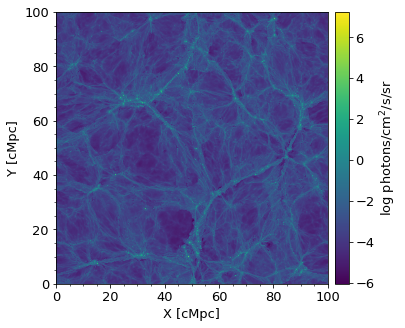

In [17]:


xystarts = [0.,0.]
size = 100.
fig = plt.figure(figsize = (6.5, 5.))
ax1 = plt.subplot(111)

get_halpha_SB.makemap(data,size,ax1,xystarts = xystarts)


The type of size is <type 'float'>


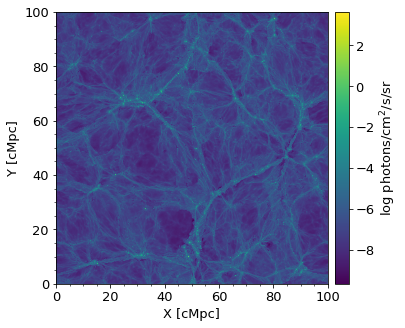

In [18]:

xystarts = [0.,0.]
size = 100.
fig = plt.figure(figsize = (6.5, 5.))
ax1 = plt.subplot(111)

get_halpha_SB.makemap(np.log10(psf_image),size,ax1,xystarts = xystarts)


In [ ]:
xystarts = [40.,0.]
size     = 20.
fig = plt.figure(figsize = (6.5, 5.))
ax1 = plt.subplot(111)
get_halpha_SB.makemap(data[(xystarts[0]/100.*8000.):((xystarts[0]+size)/100.*8000.),
                           (xystarts[1]/100.*8000.):((xystarts[1]+size)/100.*8000.)],size,ax1,xystarts = xystarts)
